<a href="https://colab.research.google.com/github/proshanta000/langgraph_l/blob/main/langgraph_chatbot_with_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Uninstall everything to clear the conflicts
#!pip uninstall -y langchain langgraph langchain-community langchain-core langchain-groq pydantic

Found existing installation: langchain 0.3.27
Uninstalling langchain-0.3.27:
  Successfully uninstalled langchain-0.3.27
Found existing installation: langchain-core 0.3.79
Uninstalling langchain-core-0.3.79:
  Successfully uninstalled langchain-core-0.3.79
Found existing installation: pydantic 2.11.10
Uninstalling pydantic-2.11.10:
  Successfully uninstalled pydantic-2.11.10


In [2]:
!pip install langgraph langsmith langchain langchain_groq langchain_community arxiv wikipedia

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.4/463.4 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [4]:
import os
from google.colab import userdata
groq_api_key = userdata.get('GROQ_API_KEY')
langsmith = userdata.get('LANGSMITH_API_KEY')

os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_chatbot_1"

In [5]:
from langchain.tools import tool
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from pydantic import BaseModel, Field

# 2. Define input schemas for the tools
class WikipediaInput(BaseModel):
    query: str = Field(description="search query for Wikipedia")

class ArxivInput(BaseModel):
    query: str = Field(description="search query for Arxiv")

# 3. Create tools using the @tool decorator.
#    Instantiate API wrappers inside the function to avoid serialization issues
@tool("wikipedia_search", args_schema=WikipediaInput)
def wikipedia_search(query: str) -> str:
    """Search Wikipedia for a given query and return the summary."""
    # Instantiate the wrapper each time the tool is called
    _wikipedia_api_wrapper_instance = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
    return _wikipedia_api_wrapper_instance.run(query)

@tool("arxiv_search", args_schema=ArxivInput)
def arxiv_search(query: str) -> str:
    """Search Arxiv for a given query and return the summary."""
    # Instantiate the wrapper each time the tool is called
    _arxiv_api_wrapper_instance = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
    return _arxiv_api_wrapper_instance.run(query)

# 4. Collect the tools
tools = [wikipedia_search, arxiv_search]

In [6]:
# Test Wikipedia tool
tools[0].invoke("who is J. K. Rowling")

'Page: Political views of J. K. Rowling\nSummary: The British author J. K. Rowling, writer of Harry Potter and other Wizarding World works, has garnered attention for her support of the Labour Party under Gordon Brown and her criticism of the party under Jeremy Corbyn and Keir Starmer, as well as her '

In [7]:
# Test Arxiv tool
tools[1].invoke("What is Machane Learning")

'Published: 2017-05-15\nTitle: Emotion in Reinforcement Learning Agents and Robots: A Survey\nAuthors: Thomas M. Moerland, Joost Broekens, Catholijn M. Jonker\nSummary: This article provides the first survey of computational models of emotion in reinforcement learning (RL) agents. The survey focuses on '

In [8]:
from langchain_core.messages import BaseMessage
# Langgraph Application
class State(TypedDict):
  # Messages have the type "list". The  "add_messages" function
  # in the annotation defines how this state key should be updated
  #(in this case, it appends messages to the list , rather than overwriting them)
    messages: Annotated[list[BaseMessage], add_messages]

In [9]:
#class State(TypedDict):
    # messages is now correctly updated using the imported add_messages
   # messages: Annotated[list, add_messages]

In [10]:
from langgraph.graph import StateGraph, START, END

In [11]:
graph_builder = StateGraph(State)

In [12]:
from langchain_groq import ChatGroq

In [13]:
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-8b-instant")

In [14]:
llam_with_tools = llm.bind_tools(tools)

In [15]:
def chatbot(state:State):
  return {"messages":[llam_with_tools.invoke(state['messages'])]}

In [16]:
from langgraph.prebuilt import ToolNode , tools_condition

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)
graph_builder.add_node("chatbot", chatbot)

# --- Edges ---
graph_builder.add_edge(START, "chatbot")

# Use the prebuilt tools_condition to check if the LLM requested a tool
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END} # Corrected: Map the actual END constant
)

graph_builder.add_edge("tools", "chatbot")
# No need for the tool -> END edge if tools_condition handles all termination

In [17]:
from langgraph.checkpoint.memory import MemorySaver
memory_saver = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory_saver
)

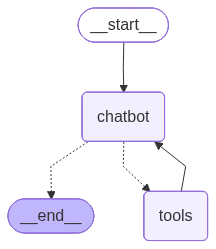

In [18]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [19]:
import uuid
user_input = "Hi there! What's in your mind?"
initial_input = {"messages": [("user", user_input)]}

# Generate a unique thread ID for a clean run
unique_thread_id = str(uuid.uuid4())

# Use invoke() to run to completion, avoiding the buggy stream logic
final_state = graph.invoke(
    initial_input,
    config={"configurable": {"thread_id": unique_thread_id}}
)

print("\n--- Output History (via Invoke) ---")

# Iterate through the full list of messages in the final state
for message in final_state["messages"]:
    try:
        if hasattr(message, 'pretty_print'):
            message.pretty_print()
        else:
            # Handle the initial tuple message
            print(f"Human Message: {message[1]}")
    except Exception as e:
        print(f"Error printing message: {e}")


--- Output History (via Invoke) ---
================================ Human Message =================================

Hi there! What's in your mind?
================================== Ai Message ==================================

I'm just a language model, I don't have personal thoughts or feelings like humans do, but I'm here to help with any questions or tasks you have. How can I assist you today?


In [21]:
while True:
  user_input=input("User: ")
  if user_input.lower() in ("quit","q"):
    print("Good Bye")
    break
  for event in graph.stream(
      {'messages':("user", user_input)},
      config={"configurable": {"thread_id": unique_thread_id}} # Added config here
      ):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      # The value['messages'] will now contain a list of messages. We need to access the last one to get the latest AI response.
      # Also, ensure we are printing the content of the message object, not the message object itself.
      latest_message = value['messages'][-1] if isinstance(value['messages'], list) else value['messages']
      if hasattr(latest_message, 'content'):
          print('Assistant:', latest_message.content)
      else:
          print('Assistant:', latest_message)

User: hi
dict_values([{'messages': [AIMessage(content="It seems like we're just starting a conversation. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 360, 'total_tokens': 387, 'completion_time': 0.042979111, 'prompt_time': 0.023832332, 'queue_time': 0.035657064, 'total_time': 0.066811443}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_d834565e05', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--a9d0df9e-dc6c-41af-a811-b41027baf501-0', usage_metadata={'input_tokens': 360, 'output_tokens': 27, 'total_tokens': 387})]}])
[AIMessage(content="It seems like we're just starting a conversation. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 360, 'total_tokens': 387, 'completi